# pc-gym showcase 
Author: Max Bloor (max.bloor22@imperial.ac.uk) \\

Notebook showcasing the current pc-gym version.


## Libraries

In [5]:
import numpy as np 
import torch
import matplotlib.pyplot as plt 
import gymnasium as gym
import torch.nn.functional as F
import copy
from stable_baselines3 import PPO,SAC
from Models import Models_env
#Global params
T = 26
nsteps = 100

## 1.1 Reactor Case Study

In [2]:
#Enter required setpoints for each state. Enter None for states without setpoints.
SP = {
    'Ca': [0.85 for i in range(int(nsteps/2))] + [0.9 for i in range(int(nsteps/2))],
}

#Continuous box action space
action_space = {
    'low': np.array([295]),
    'high':np.array([302]) 
}
#Continuous box observation space
observation_space = {
    'low' : np.array([0.7,300,0.8]),
    'high' : np.array([1,350,0.9])  
}

r_scale ={
    'Ca': 5 #Reward scale for each state
}
env_params = {
    'Nx': 2, # Number of states
    'N': nsteps, # Number of time steps
    'tsim':T, # Simulation Time
    'Nu':1, # Number of control/actions
    'SP':SP, #Setpoint
    'o_space' : observation_space, #Observation space
    'a_space' : action_space, # Action space
    'x0': np.array([0.8,330,0.8]), # Initial conditions (torch.tensor)
    'model': 'cstr_ode', #Select the model
    'r_scale': r_scale, #Scale the L1 norm used for reward (|x-x_sp|*r_scale)
    'normalise_a': True, #Normalise the actions
    'normalise_o':True, #Normalise the states,
    'noise':True, #Add noise to the states
    'integration_method': 'casadi', #Select the integration method
    'noise_percentage':0.001 #Noise percentage
}
env = Models_env(env_params)


In [3]:
initial_policy = SAC('MlpPolicy', env, verbose=1,learning_rate=0.01).learn(2e3)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 60       |
|    ep_rew_mean     | -0.307   |
| time/              |          |
|    episodes        | 4        |
|    fps             | 88       |
|    time_elapsed    | 2        |
|    total_timesteps | 240      |
| train/             |          |
|    actor_loss      | -0.546   |
|    critic_loss     | 0.00187  |
|    ent_coef        | 0.25     |
|    ent_coef_loss   | -2.34    |
|    learning_rate   | 0.01     |
|    n_updates       | 139      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 60       |
|    ep_rew_mean     | -0.34    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 88       |
|    time_elapsed    | 5        |
|    total_timesteps | 480      |
| train/             

In [4]:
initial_policy.save("SAC_cstr")

In [3]:
initial_policy = SAC.load("SAC_cstr")

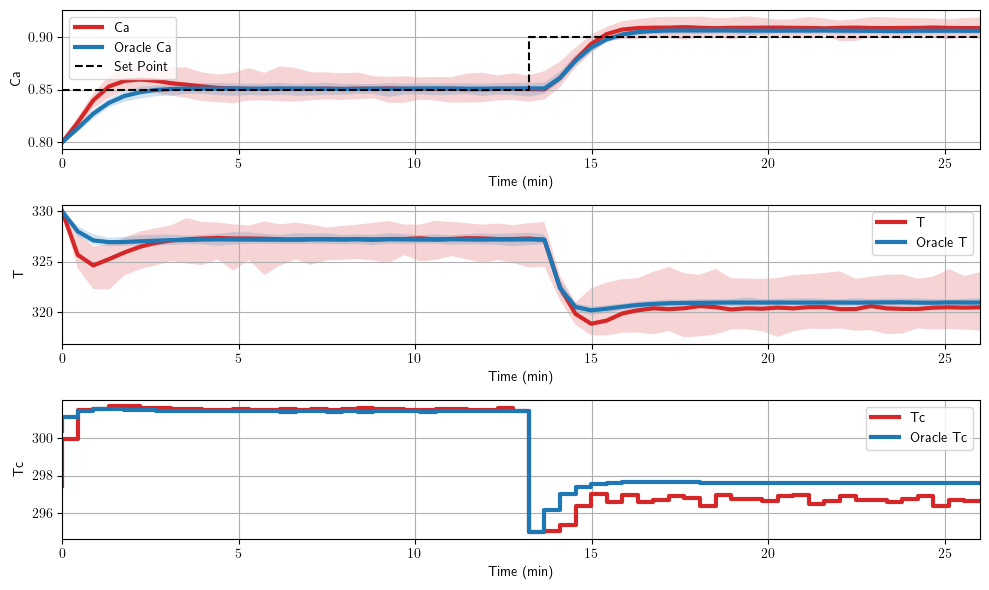

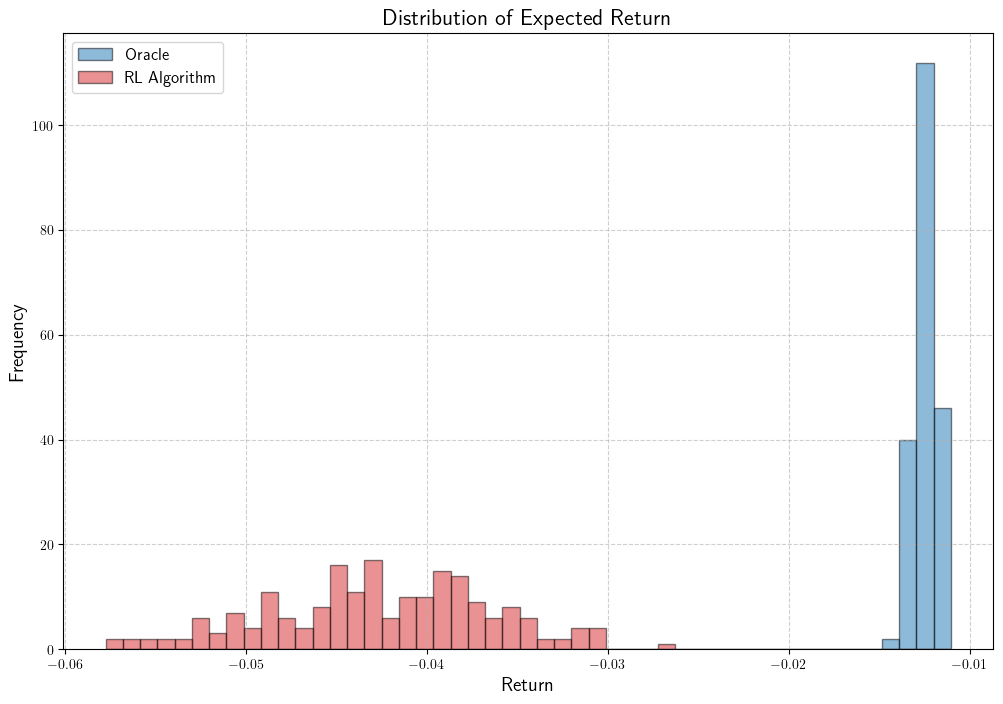

In [6]:
env.plot_rollout(initial_policy,200,oracle = True,dist_reward=True)


### 1.1.1 Reactor with JAX 

In [ ]:
#Enter required setpoints for each state. Enter None for states without setpoints.
SP = {
    '0': [0.8 for i in range(int(nsteps/2))] + [0.9 for i in range(int(nsteps/2))],
}

#Continuous box action space
action_space = {
    'low': np.array([295]),
    'high':np.array([302]) 
}
#Continuous box observation space
observation_space = {
    'low' : np.array([0.7,300,0.8]),
    'high' : np.array([1,350,0.9])  
}

r_scale ={
    '0': 5
}
env_params = {
    'Nx': 2, # Number of states
    'N': nsteps, # Number of time steps
    'tsim':T, # Simulation Time
    'Nu':1, # Number of control/actions
    'SP':SP, #Setpoint
    'o_space' : observation_space, #Observation space
    'a_space' : action_space, # Action space
    'dt': 1., # Time step
    'x0': np.array([0.8,330,0.8]), # Initial conditions (torch.tensor)
    'model': 'cstr_ode_jax', #Select the model
    'r_scale': r_scale, #Scale the L1 norm used for reward (|x-x_sp|*r_scale)
    'normalise_a': True, #Normalise the actions
    'normalise_o':True, #Normalise the states,
    'noise':True, #Add noise to the states
    'integration_method': 'jax',
    'noise_percentage':0.001
}
env = Models_env(env_params)

In [ ]:
initial_policy = SAC('MlpPolicy', env, verbose=1,learning_rate=0.01).learn(3e4)

### 1.2 First Order System 

In [10]:
SP = {
    'x': [5 for i in range(int(nsteps/2))] + [8 for i in range(int(nsteps/2))]
}

action_space = {
    'low': np.array([0]),
    'high':np.array([10]) 
}

observation_space = {
    'low' : np.array([0,4]),
    'high' : np.array([10,6])  
}

r_scale = {
    'x': 1,
}
env_params_fos = {
    'Nx': 1,
    'N': nsteps,
    'tsim':T,
    'Nu':1,
    'SP':SP,
    'o_space' : observation_space,
    'a_space' : action_space,
    'dt': 1,
    'x0': np.array([0.,5.]),
    'model': 'first_order_system_ode', 
    'r_scale': r_scale,
    'normalise_a': True, #Normalise the actions
    'normalise_o':True, #Normalise the states,
    'noise':False, #Add noise to the states
    'noise_percentage':0.01,
    'integration_method': 'casadi'
}
first_order_env = Models_env(env_params_fos)

In [ ]:
fos_policy = SAC('MlpPolicy', first_order_env, verbose=1,learning_rate=0.001).learn(1e4)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -105     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 82       |
|    time_elapsed    | 4        |
|    total_timesteps | 400      |
| train/             |          |
|    actor_loss      | 6.41     |
|    critic_loss     | 2.26     |
|    ent_coef        | 0.856    |
|    ent_coef_loss   | -0.0778  |
|    learning_rate   | 0.001    |
|    n_updates       | 299      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -51.5    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 77       |
|    time_elapsed    | 10       |
|    total_timesteps | 800      |
| train/             

In [6]:
fos_policy.save("SAC_fos")

NameError: name 'fos_policy' is not defined

In [11]:
fos_policy =  SAC.load("SAC_fos")

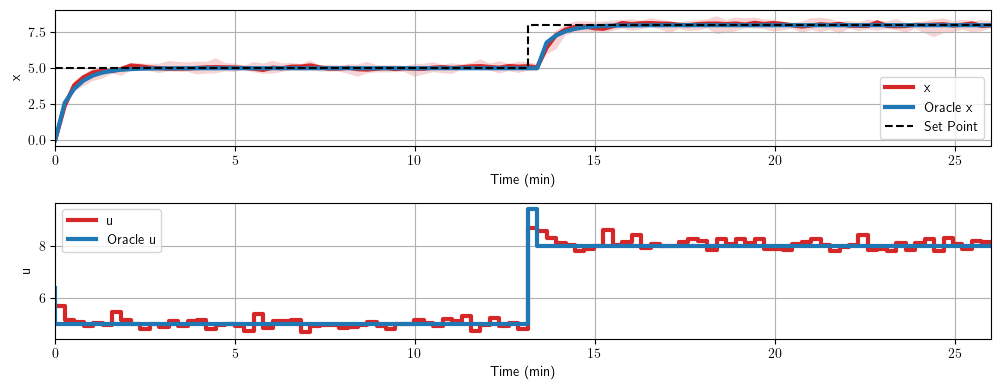

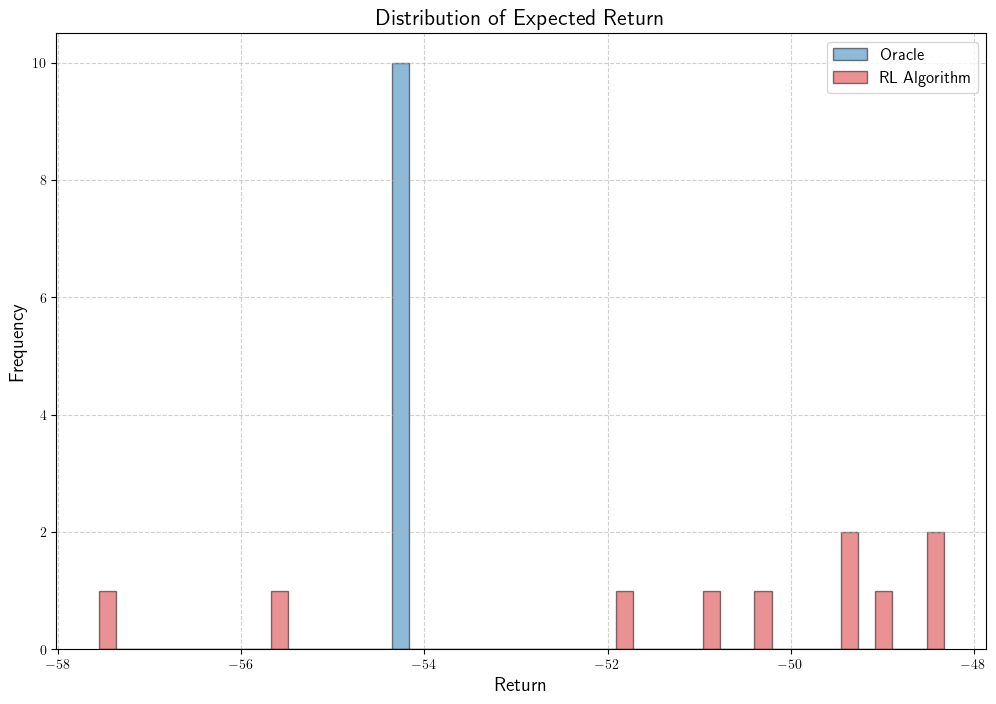

In [12]:
first_order_env.plot_rollout(fos_policy,10,oracle=True,dist_reward=True,MPC_params={'N':10,'R':0.0})

### 1.3 Multi-Stage Extraction Column

In [6]:
SP = {
      'X5': [0.3 for i in range(int(nsteps/4))] + [0.4 for i in range(int(nsteps/2))]+ [0.3 for i in range(int(nsteps/4))],
  }

action_space = {
    'low': np.array([5,10]),
    'high':np.array([500,1000])
}

observation_space = {
    'low' : np.array([0]*10+[0.3]),
    'high' : np.array([1]*10+[0.4])  
}


r_scale = {
    'X5': 1
}
env_params_ms = {
    'Nx': 10,
    'N': nsteps,
    'tsim':T,
    'Nu':2,
    'SP':SP,
    'o_space' : observation_space,
    'a_space' : action_space,
    'dt': 1,
    'x0': np.array([0.55, 0.3, 0.45, 0.25, 0.4, 0.20, 0.35, 0.15, 0.25, 0.1,0.3]),
    'model': 'multistage_extraction_ode', 
    'r_scale': r_scale,
    'normalise_a': True, #Normalise the actions
    'normalise_o':True, #Normalise the states,
    'noise':False, #Add noise to the states
    'noise_percentage':0,
    'integration_method': 'casadi'
}
multistage_env = Models_env(env_params_ms)



In [ ]:
ms_policy = SAC.load("SAC_multistage")
#ms_policy = SAC('MlpPolicy', multistage_env, verbose=1,learning_rate=0.001).learn(1e4)

In [3]:
ms_policy = SAC.load('SAC_multistage.zip')

CasADi - 2024-02-14 14:26:05 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 40, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-02-14 14:26:05 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 42, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-02-14 14:26:05 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 20, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-02-14 14:26:07 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 40, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-02-14 14:26:07 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 42, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-02-14 14:26:07 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 40, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-02-14 14:26:07 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 30, co

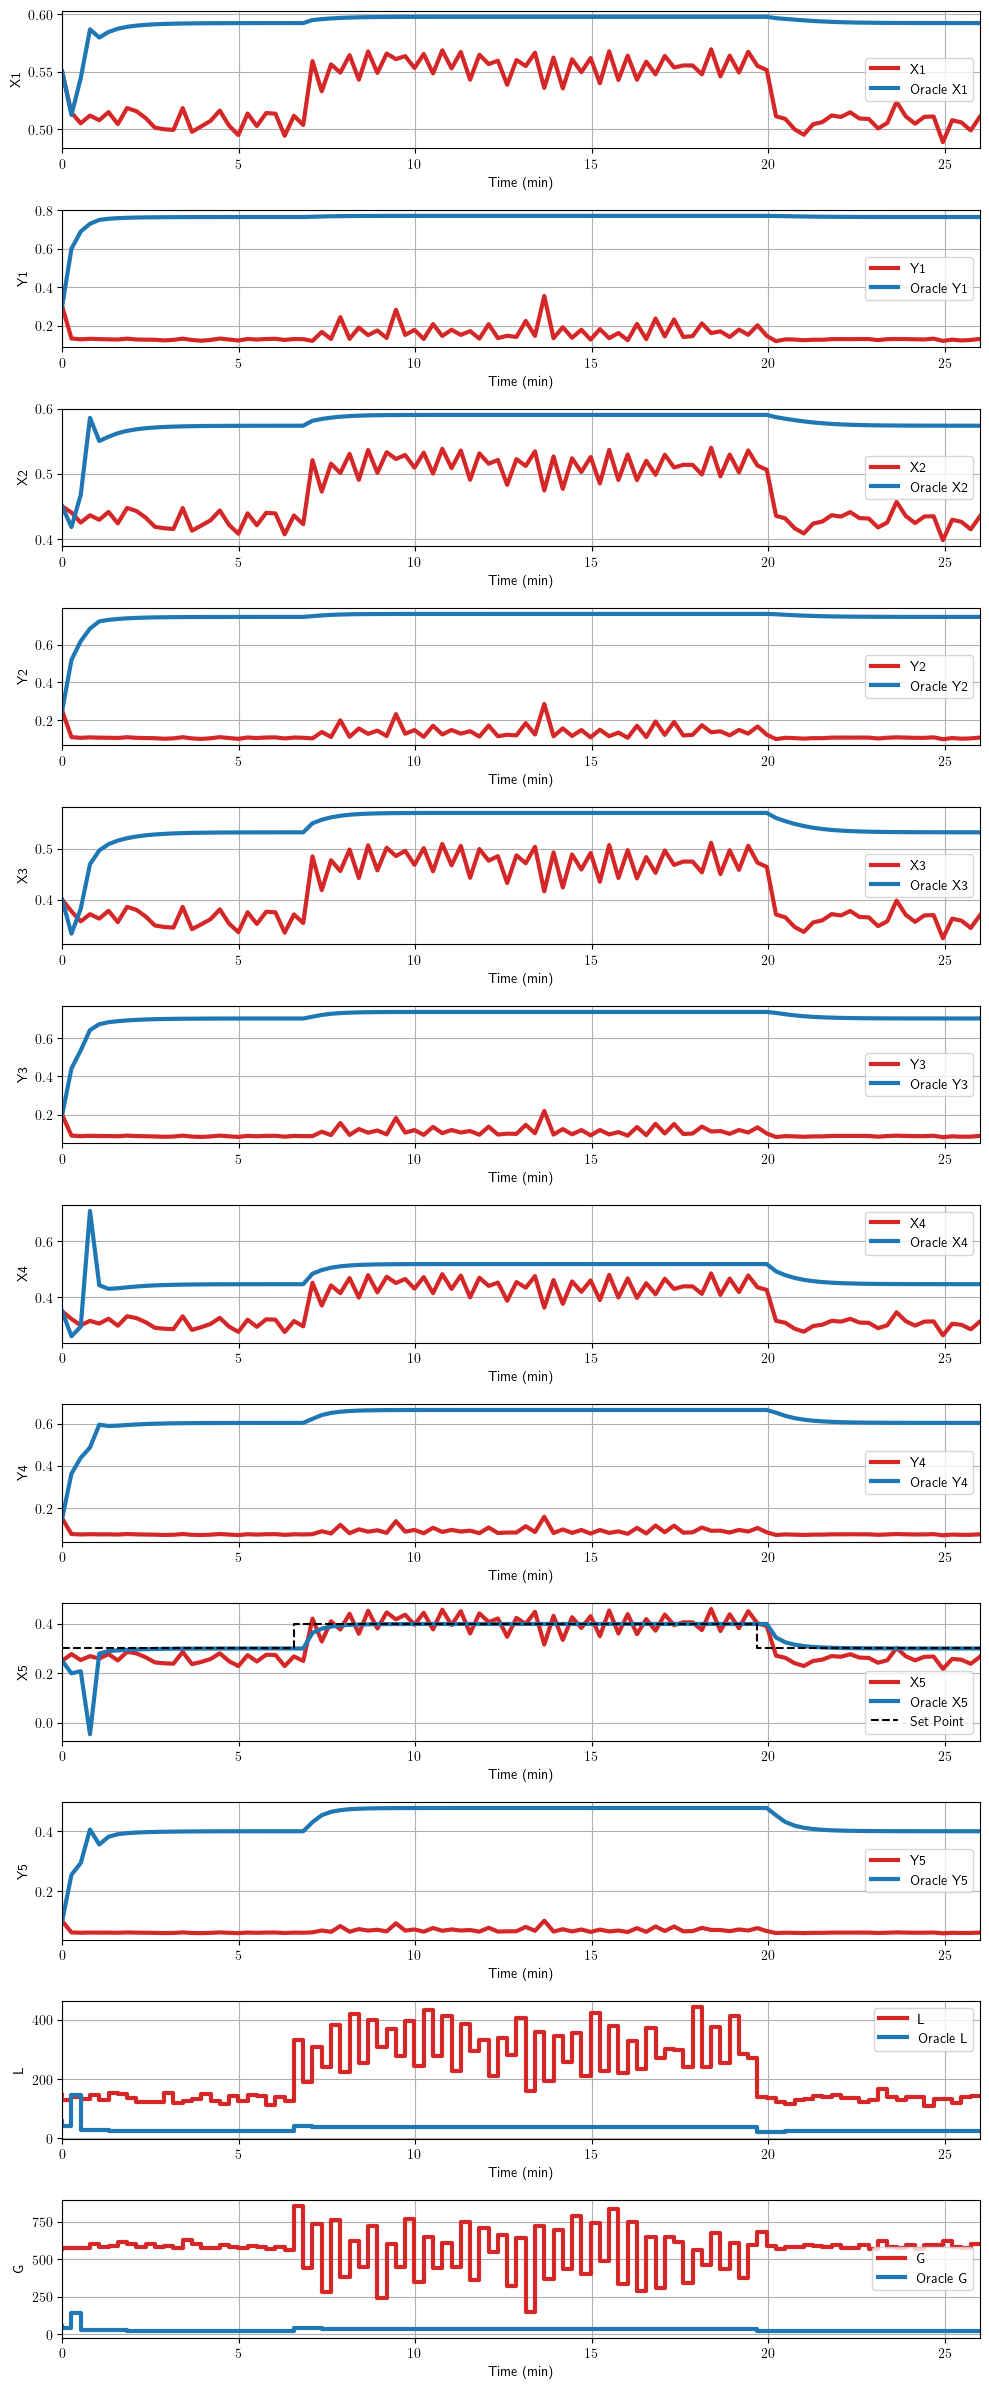

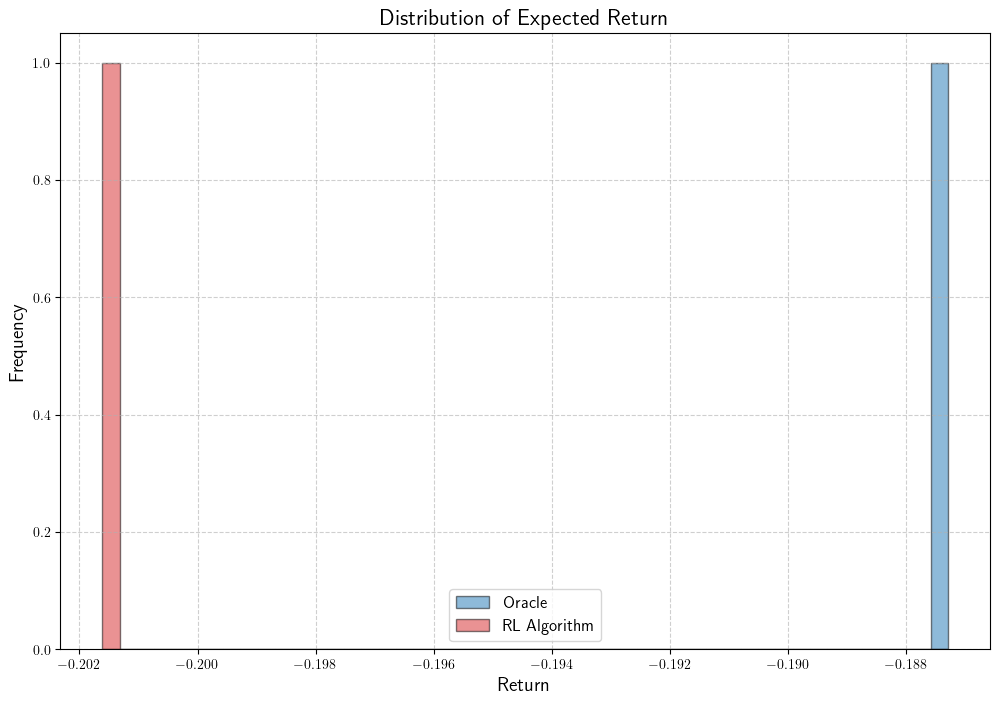

In [7]:
multistage_env.plot_rollout(ms_policy,1,oracle=True,dist_reward=True)

In [11]:
k = 'X5'
multistage_env.model.info()['states'].index(k)
SP[k]

[0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3]

## 2. Disturbance Function

### 2.1 Reactor Disturbance

Step disturbance to the inlet concentration between ~6 and ~19 minutes into the episode is defined. Then the previously trained policy is rolled out with this disturbance. 

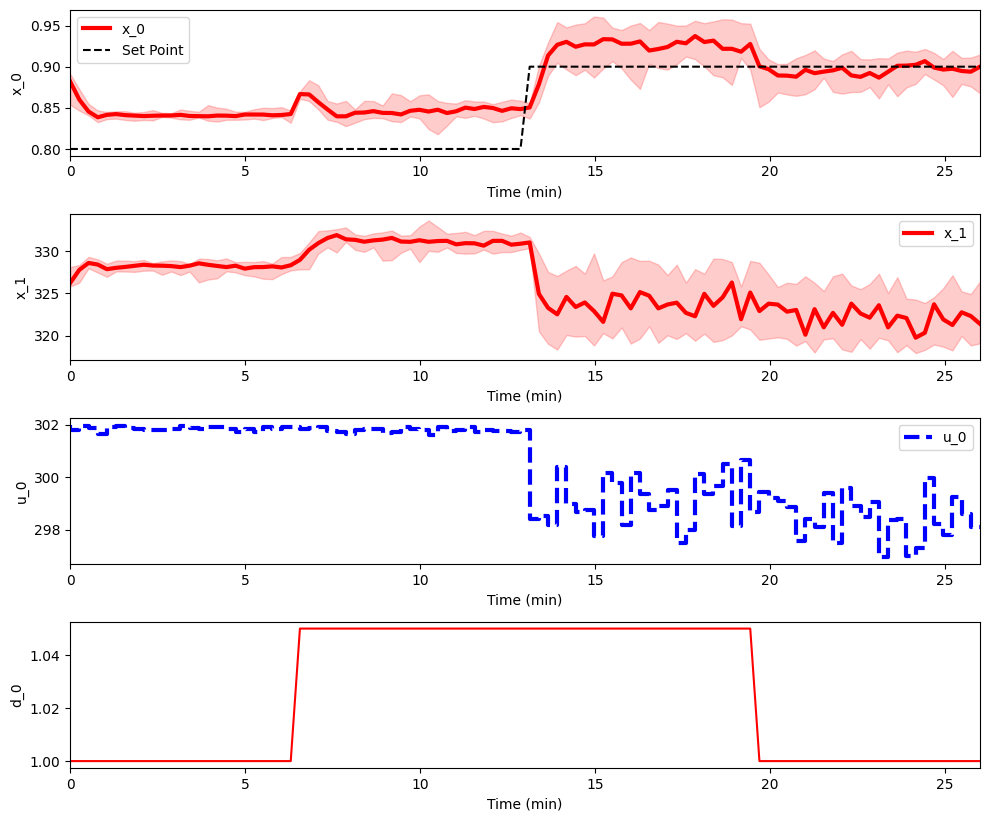

In [ ]:
disturbance = {
    '0': np.array([None for i in range(nsteps)]),
    '1': np.array([1 for i in range(int(nsteps/4))]+[1.05 for i in range(int(nsteps/2))]+[1 for i in range(int(nsteps/4))]),
}

env_params.update({'disturbances': disturbance,})
                

env = Models_env(env_params)

env.plot_rollout(initial_policy,10)

Given the previous policy's poor performance the policy is retrained on episodes with the disturbance. 

In [ ]:
dist_policy = PPO('MlpPolicy', env, verbose=1,learning_rate=0.01).learn(total_timesteps=30000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -3.64    |
| time/              |          |
|    fps             | 275      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -2.75        |
| time/                   |              |
|    fps                  | 232          |
|    iterations           | 2            |
|    time_elapsed         | 17           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0054898513 |
|    clip_fraction        | 0.079        |
|    clip_range           | 0.2          |
|    e

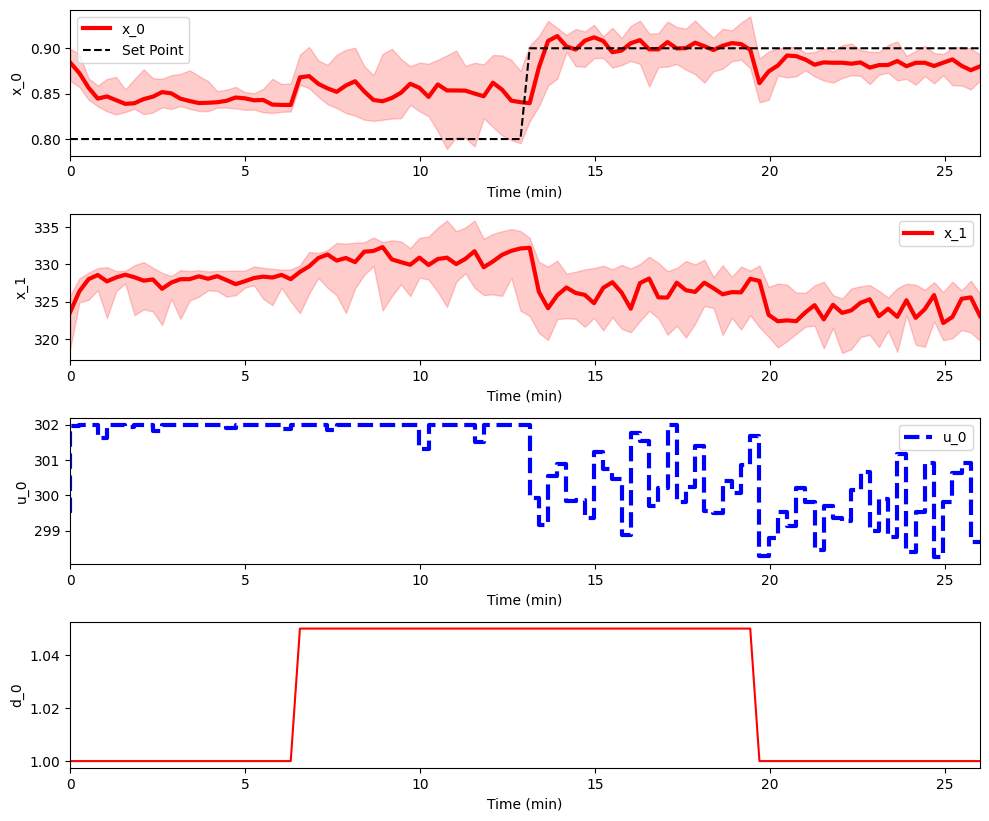

In [ ]:
env.plot_rollout(dist_policy,10)   

### 2.2 Multistage Extraction 

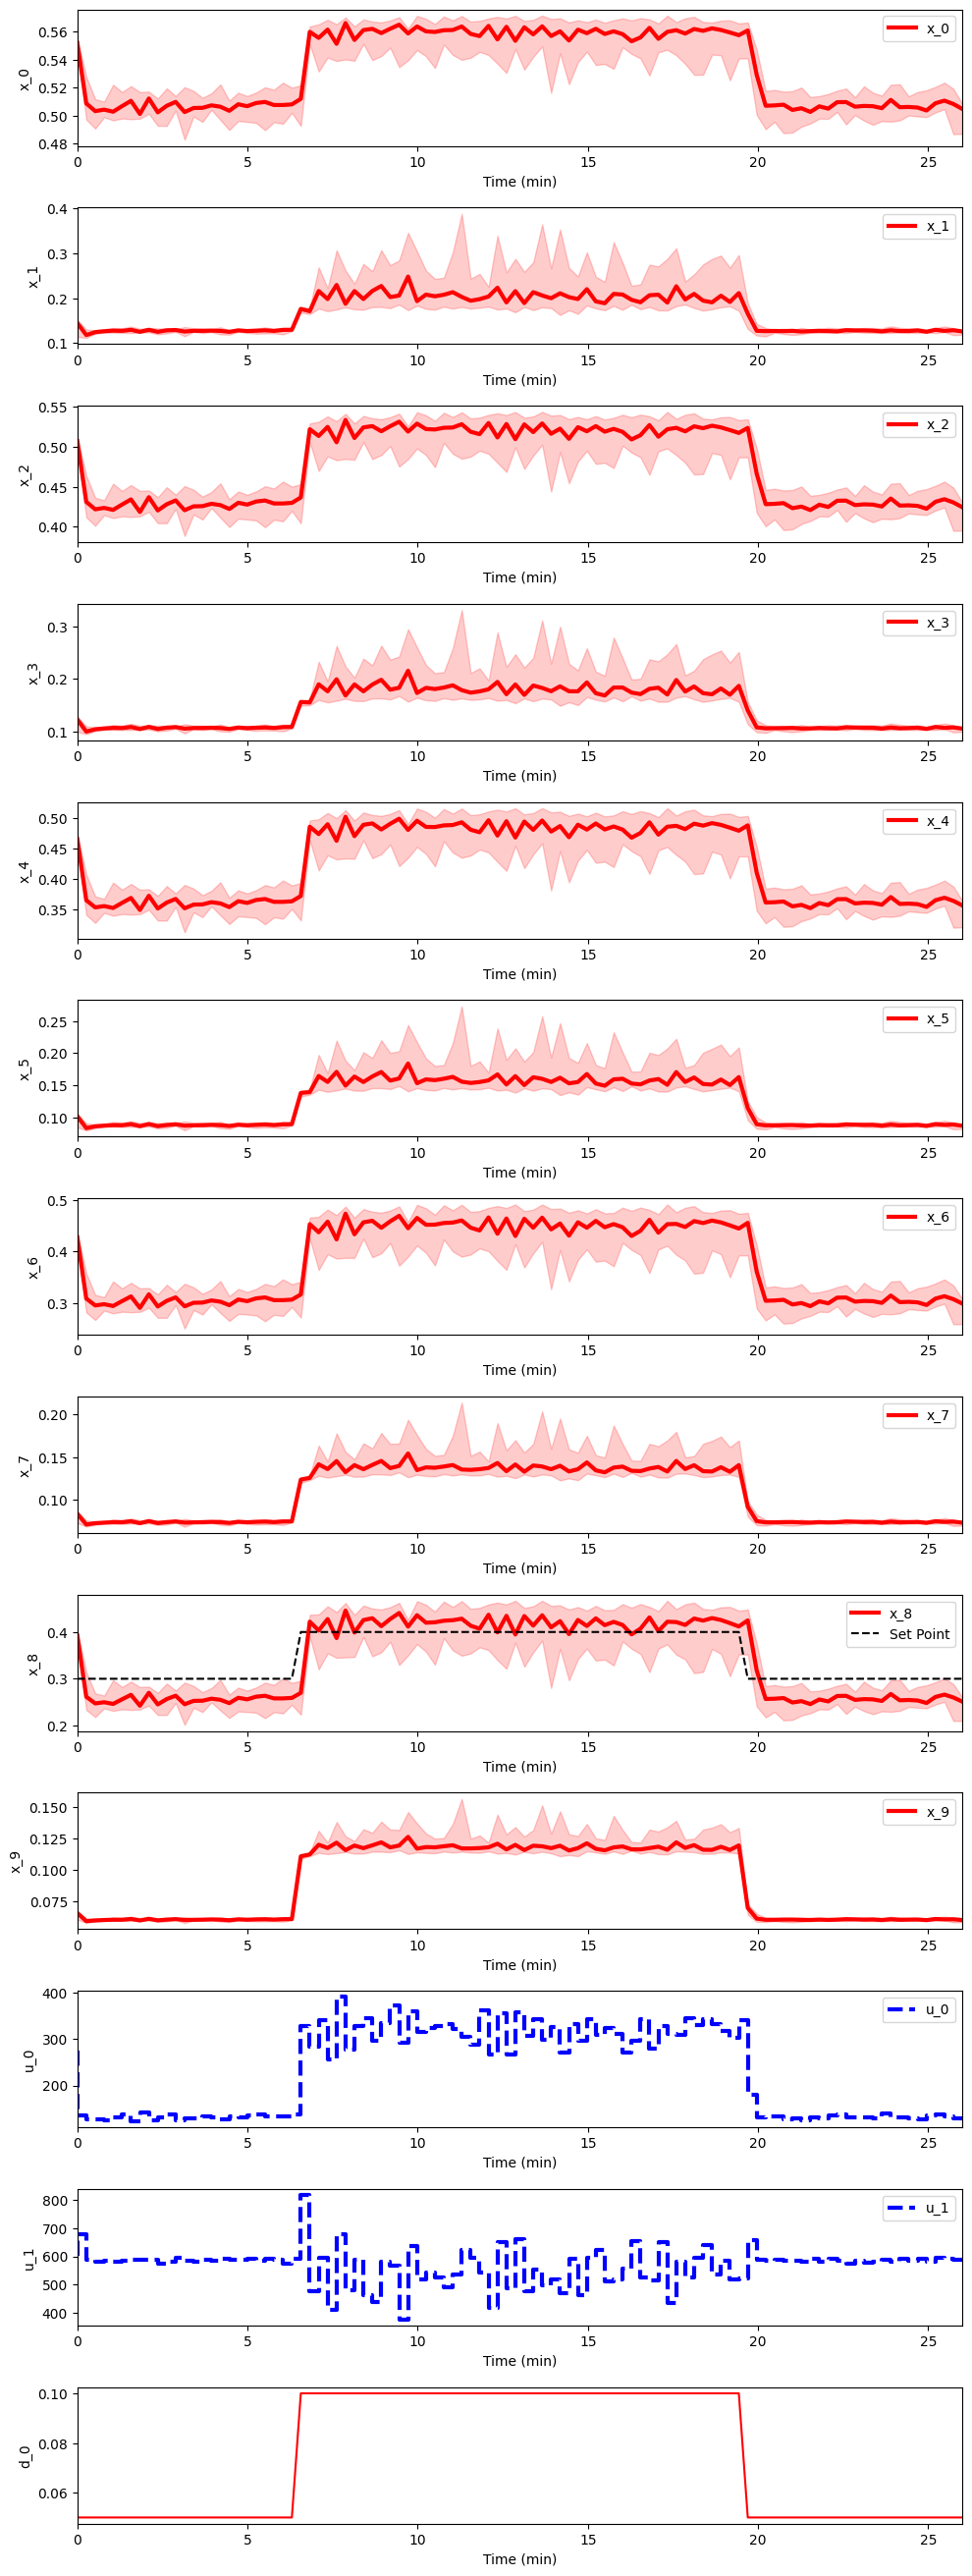

In [ ]:
disturbance = {
    '0': np.array([None for i in range(nsteps)]),
    '1': np.array([0.05 for i in range(int(nsteps/4))]+[0.1 for i in range(int(nsteps/2))]+[0.05 for i in range(int(nsteps/4))]),
}

env_params_ms.update({'disturbances': disturbance,})
                

multistage_env = Models_env(env_params_ms)

multistage_env.plot_rollout(ms_policy,10)

## 3. Constraint Function

### 3.1 Reactor Constraint

The constraint is defined in the environment and the reward penalty is activated to encourage policies which do not violate the constraint.

In [ ]:
cons = {
    '0': None,
    '1' :330
}

cons_type = {
    '1':'<='
}

env_params.update({
'done_on_cons_vio':False,
'constraints': cons, 
'cons_type': cons_type,
'r_penalty': True})
env_params.get('constraints') is not None
env = Models_env(env_params)

A constraint is shown at a reactor temperature of 332 K.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


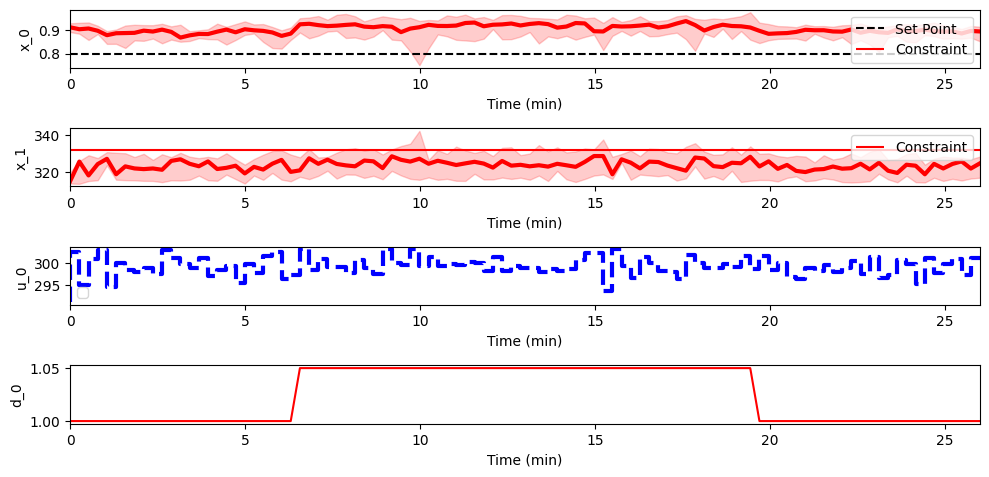

In [ ]:
env.plot_rollout(dist_policy,10)

Train with the constraint penalty

In [ ]:
cons_policy = PPO('MlpPolicy', env, verbose=1,learning_rate=0.01).learn(total_timesteps=30000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -2.33    |
| time/              |          |
|    fps             | 244      |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -2.01       |
| time/                   |             |
|    fps                  | 197         |
|    iterations           | 2           |
|    time_elapsed         | 20          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009269759 |
|    clip_fraction        | 0.0946      |
|    clip_range           | 0.2         |
|    entropy_loss  

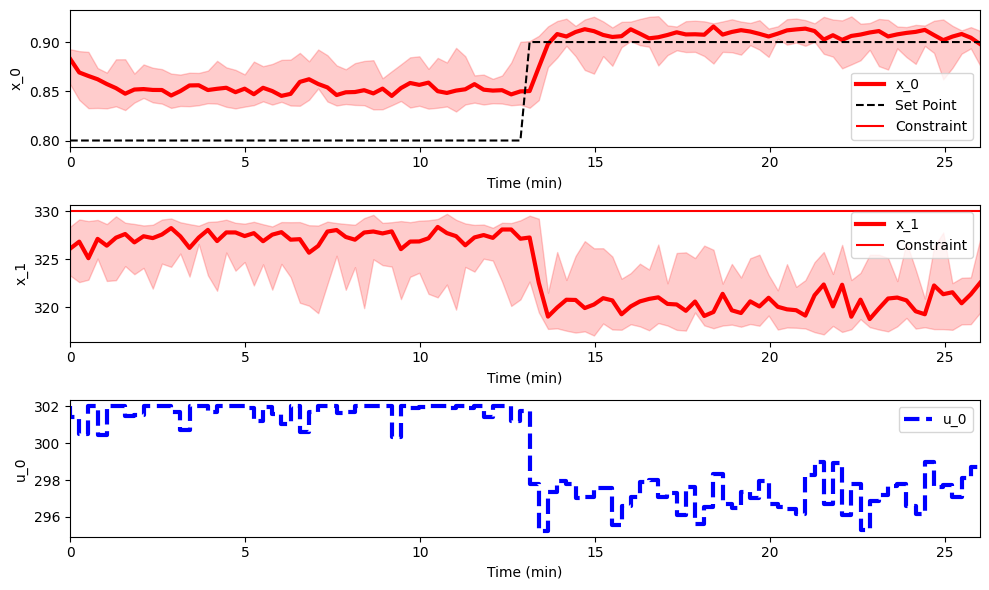

In [ ]:
env.plot_rollout(cons_policy,10)

### 3.2 First-Order-System Constraint

In [ ]:
cons = {
    '0': 9,
}

cons_type = {
    '0':'<='
}

env_params_fos.update({
'done_on_cons_vio':False,
'constraints': cons, 
'cons_type': cons_type,
'r_penalty': True})
env_params_fos.get('constraints') is not None
env = Models_env(env_params_fos)

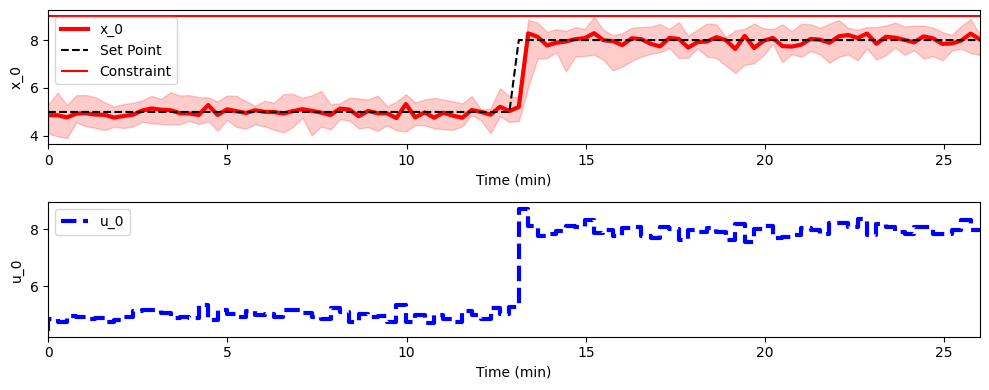

In [ ]:
env.plot_rollout(fos_policy,10)

### 3.3 Multistage Extraction Constraint 

In [ ]:
cons = {
    '0': 0.6,
    '1' :None
}

cons_type = {
    '0':'<='
}

env_params_ms.update({
'done_on_cons_vio':False,
'constraints': cons, 
'cons_type': cons_type,
'r_penalty': True})
env_params_ms.get('constraints') is not None
env = Models_env(env_params_ms)

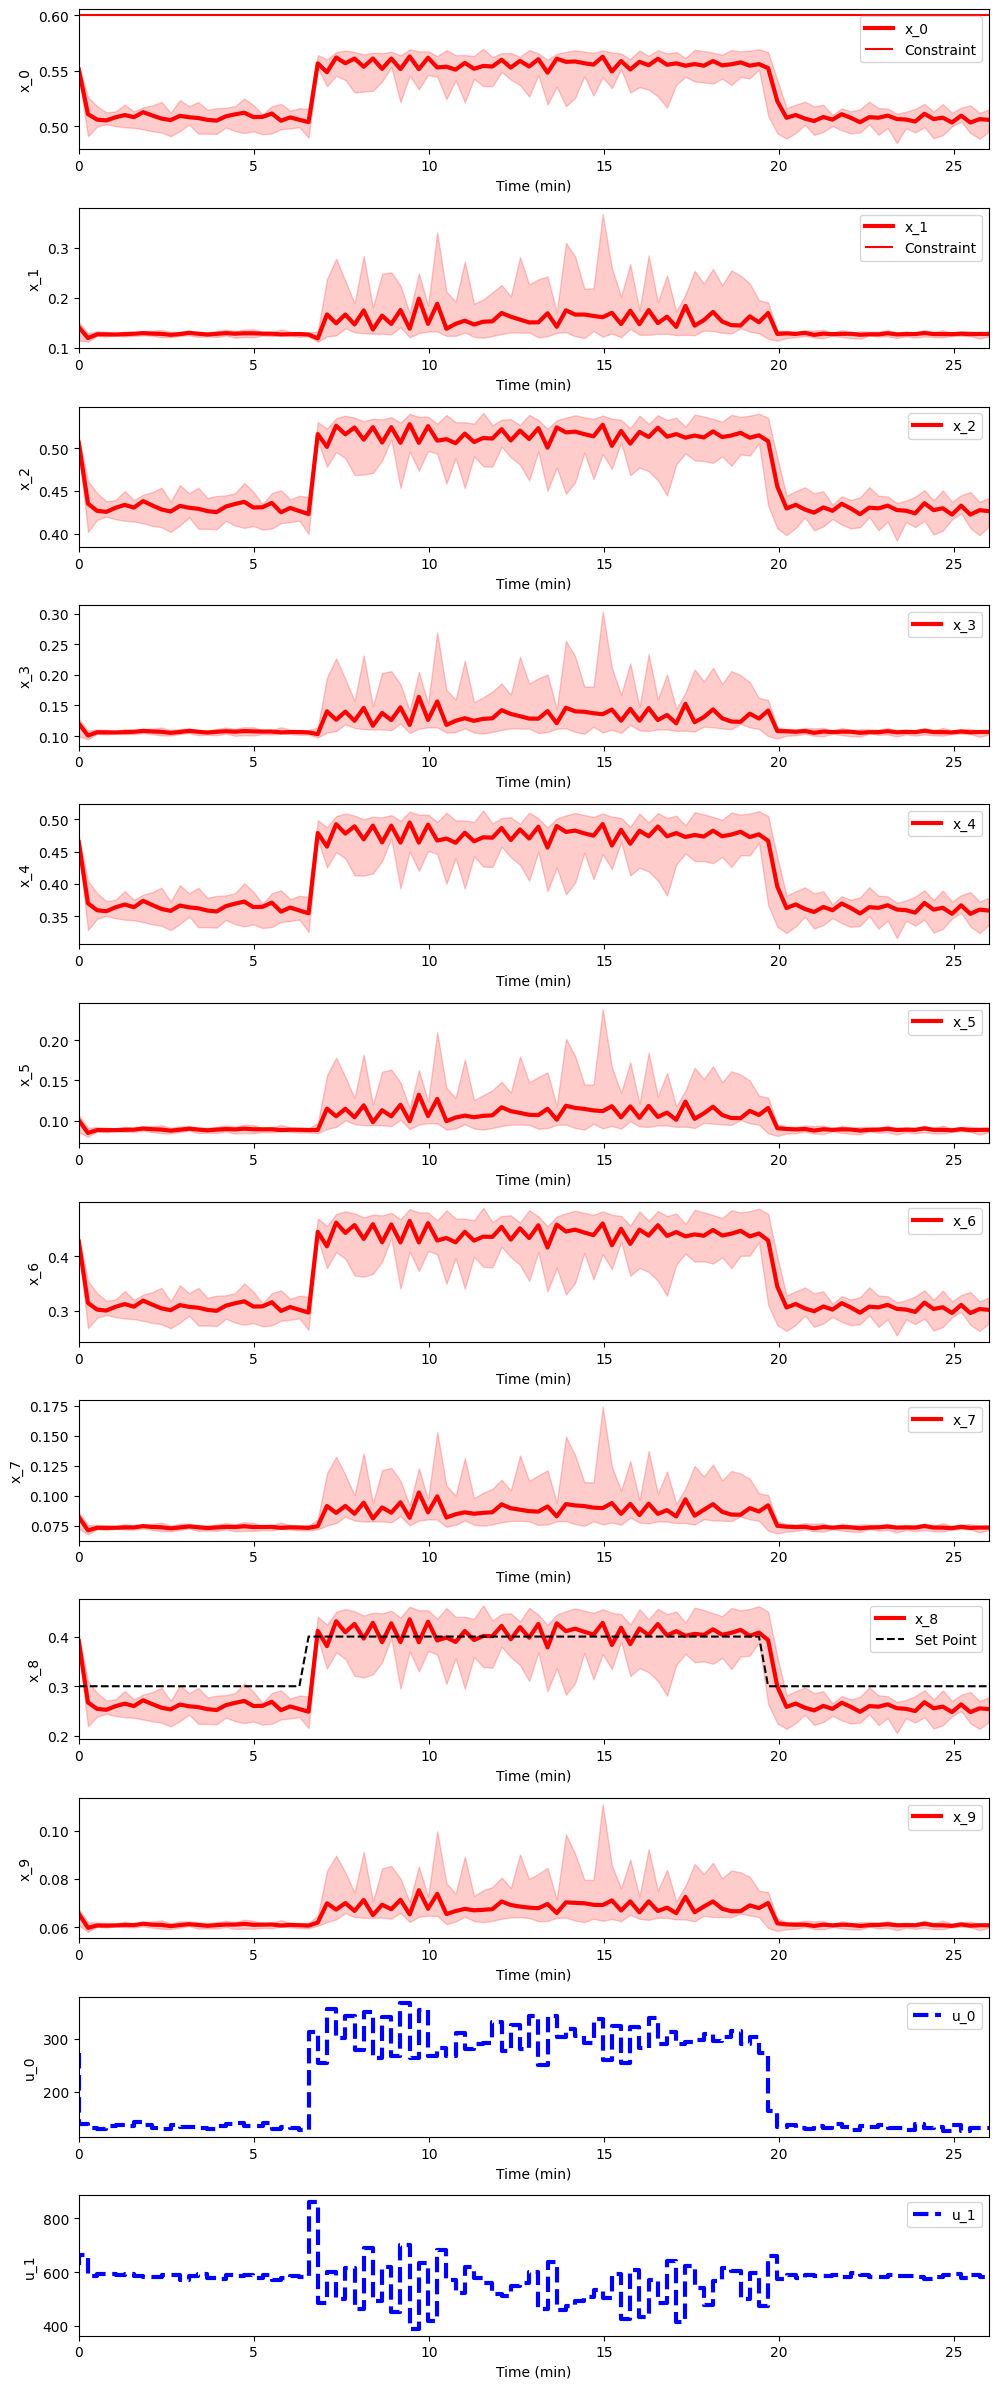

In [ ]:
env.plot_rollout(ms_policy,10)